# NGX Stock Price Forecasting.

This notebook forecasts Nigerian Exchange (NGX) stock prices with **this dataset** (`NGX Stocks 2000 - 2025.csv`) with **Prophet**.
It includes different companies on the Nigeria Stock Exchange (NGX), generates 12-month-ahead forecasts, and saves charts (PNG) and results (CSV) to folders.

**Outputs created when you run it locally:**
- `images/` — forecast charts
- `data/` — forecast CSV files


In [196]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

# Create output folders if they don't exist
os.makedirs("images", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [197]:
# Load CSV
stocks = pd.read_csv("C:/Users/DELL/Documents/favoured/datasets/Nigeria Finanical Market Data/NGX Stocks 2000 - 2025.csv")

# Harmonize column names
if 'Company' not in stocks.columns and 'Symbol' in stocks.columns:
    stocks = stocks.rename(columns={'Symbol':'Company'})

# Parse dates
stocks['Date'] = pd.to_datetime(stocks['Date'], errors='coerce')
stocks = stocks.dropna(subset=['Date']).sort_values('Date')

# Quick check for required columns
required = {'Date','Company','Price'}
missing = required - set(stocks.columns)
if missing:
    raise ValueError(f"Missing required columns: {missing}. Please rename columns to match: Date, Company, Close.")

stocks.head()

,Company,Sector,Date,index,Price,Open,High,Low,Change %,vol multiplier,Volume,Company Name,SubSector,Market Classification,Shares Outstanding,Market Cap
184559,NB,CONSUMER GOODS,2000-01-03,4999,0.14,13.60,13.71,13.60,0.00%,1000000.0,2360000.0,NIGERIAN BREW. PLC.,Beverages--Brewers/Distillers,Main Board,3.098303e+10,4.337624e+09
262258,TRANSEXPR,SERVICES,2000-01-03,2793,0.90,0.90,0.90,0.90,0.00%,NaN,NaN,TRANS-NATIONWIDE EXPRESS PLC.,Courier/Freight/Delivery,Main Board,4.981501e+08,4.483351e+08
28340,BETAGLAS,INDUSTRIAL GOODS,2000-01-03,4701,5.73,5.73,5.73,5.73,0.00%,NaN,NaN,BETA GLASS PLC.,Packaging/Containers,Main Board,5.999664e+08,3.437807e+09
49435,CILEASING,SERVICES,2000-01-03,4999,2.83,2.83,2.83,2.83,0.00%,NaN,NaN,C & I LEASING PLC.,Support and Logistics,Main Board,2.948577e+09,8.344473e+09
7207,ACADEMY,SERVICES,2000-01-03,3778,0.52,0.52,0.52,0.52,0.00%,NaN,NaN,ACADEMY PRESS PLC.,Printing/Publishing,Main Board,7.560000e+08,3.931200e+08


Top 5 Companies by Trading Volume:
Company Name
FIRST HOLDCO PLC                 8.659913e+10
ZENITH BANK PLC                  8.534334e+10
NIGERIAN BREW. PLC.              8.274297e+10
UNITED BANK FOR AFRICA PLC       8.232594e+10
TRANSNATIONAL CORPORATION PLC    7.273910e+10
Name: Volume, dtype: float64


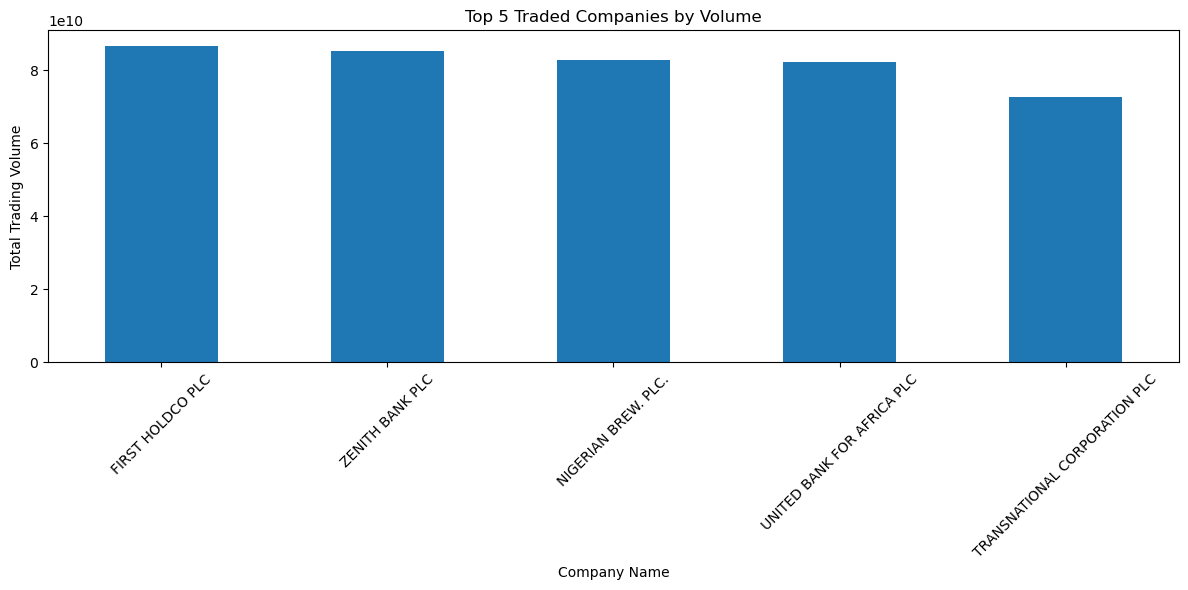

Saved: data/top_5_stocks_data.csv and images/top_5_stocks_by_vol*.png


In [198]:
# Calculate total trading volume per company
if 'Volume' in stocks.columns:
    # Group by company and sum the trading volume
    top_traded = stocks.groupby('Company Name')['Volume'].sum().sort_values(ascending=False)
    
    # Get top 5 companies by trading volume
    top_5_companies = top_traded.head(5)
    
    print("Top 5 Companies by Trading Volume:")
    print(top_5_companies)

    # Creating a DataFrame from the Series.
    top_5_company_names = top_5_companies.index.tolist()
    top_5_stocks_data = stocks[stocks['Company Name'].isin(top_5_company_names)]
    
    #Creating a bar chart to visualize
    plt.figure(figsize=(12, 6))
    top_5_companies.plot(kind='bar')
    plt.title('Top 5 Traded Companies by Volume')
    plt.ylabel('Total Trading Volume')
    plt.xlabel('Company Name')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("images/Top_5_Companies_by_Trading_Volume.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Save results
    out_csv = "data/top_5_stocks_data.csv"
    top_5_stocks_data.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv} and images/top_5_stocks_by_vol*.png")

else:
    print("No 'Volume' column found. Please specify the column that contains trading volume data.")

In [199]:
def forecast_company(company_name, periods=365):
    
    # Get data for the company and prepare it for Prophet
    data = stocks[stocks['Company Name'] == company_name].copy()
    
    # Prophet requires columns named 'ds' and 'y'
    # Assuming the dataframe has date and close price columns with different names
    # Rename them to match Prophet's requirements
    data = data.rename(columns={
        'Date': 'ds',  # Replace 'Date' with your actual date column name
        'Price': 'y'   # Replace 'Price' with your actual price column name
    })
    
    # Making sure we only keep the required columns
    data = data[['ds', 'y']]
    
    model = Prophet()
    model.fit(data)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    
    # Forecast plot
    fig = model.plot(forecast)
    plt.title(f"Forecast for {company_name}")
    plt.xlabel("Date"); plt.ylabel("Close Price")
    plt.tight_layout()
    plt.savefig(f"images/{company_name}_forecast.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Components
    fig2 = model.plot_components(forecast)
    plt.tight_layout()
    plt.savefig(f"images/{company_name}_forecast_components.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Save results
    out_csv = f"data/{company_name}_forecast.csv"
    forecast.to_csv(out_csv, index=False)
    print(f"Saved: {out_csv} and images/{company_name}_*.png")
    return forecast

# Get unique companies from your dataset
companies = sorted(stocks['Company Name'].dropna().unique().tolist())
print("Available companies:")
for i, company in enumerate(companies):
    print(f"Index {i}: {company}")

Available companies:
Index 0: ABBEY MORTGAGE BANK PLC
Index 1: ACADEMY PRESS PLC.
Index 2: ACCESS HOLDINGS PLC
Index 3: AFRICA PRUDENTIAL PLC
Index 4: AFRICAN ALLIANCE INSURANCE PLC
Index 5: AFROMEDIA PLC
Index 6: AIICO INSURANCE PLC.
Index 7: AIRTEL AFRICA PLC
Index 8: ALUMINIUM EXTRUSION IND. PLC.
Index 9: ARADEL HOLDINGS PLC
Index 10: ASO SAVINGS AND LOANS PLC
Index 11: ASSOCIATED BUS COMPANY PLC
Index 12: AUSTIN LAZ & COMPANY PLC
Index 13: AXAMANSARD INSURANCE PLC
Index 14: BERGER PAINTS PLC
Index 15: BETA GLASS PLC.
Index 16: BRICLINKS AFRICA PLC
Index 17: BUA CEMENT PLC
Index 18: BUA FOODS PLC
Index 19: C & I LEASING PLC.
Index 20: CADBURY NIGERIA PLC.
Index 21: CAP PLC
Index 22: CAVERTON OFFSHORE SUPPORT GRP PLC
Index 23: CHAMPION BREW. PLC.
Index 24: CHAMS HOLDING COMPANY PLC
Index 25: CHAPEL HILL DENHAM NIG. INFRAS DEBT FUND
Index 26: CHELLARAMS PLC.
Index 27: CONOIL PLC
Index 28: CONSOLIDATED HALLMARK HOLDINGS PLC
Index 29: CORNERSTONE INSURANCE PLC
Index 30: CORONATION INSUR

Running forecast for: FIRST HOLDCO PLC


15:39:56 - cmdstanpy - INFO - Chain [1] start processing
15:39:57 - cmdstanpy - INFO - Chain [1] done processing


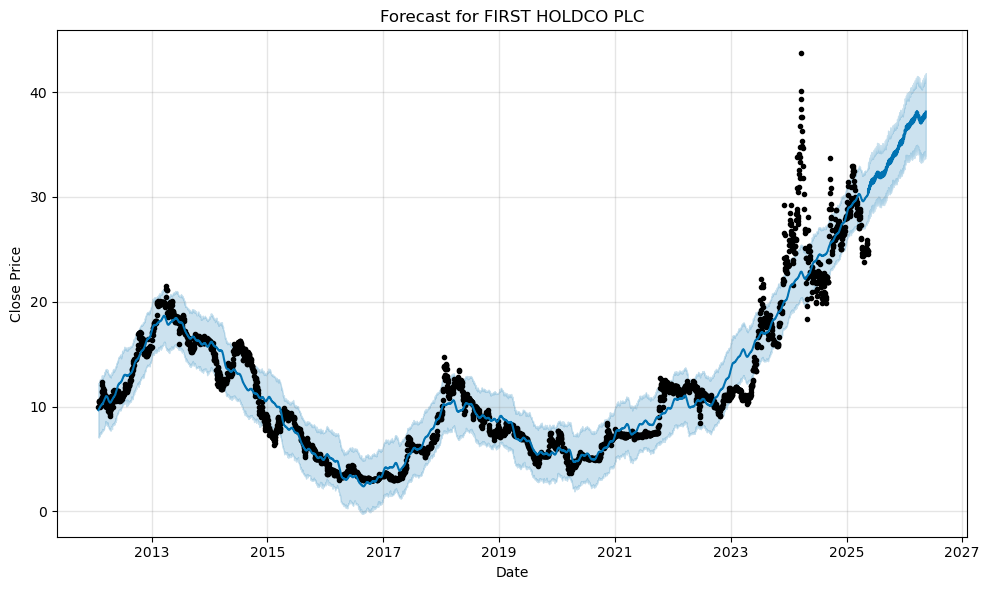

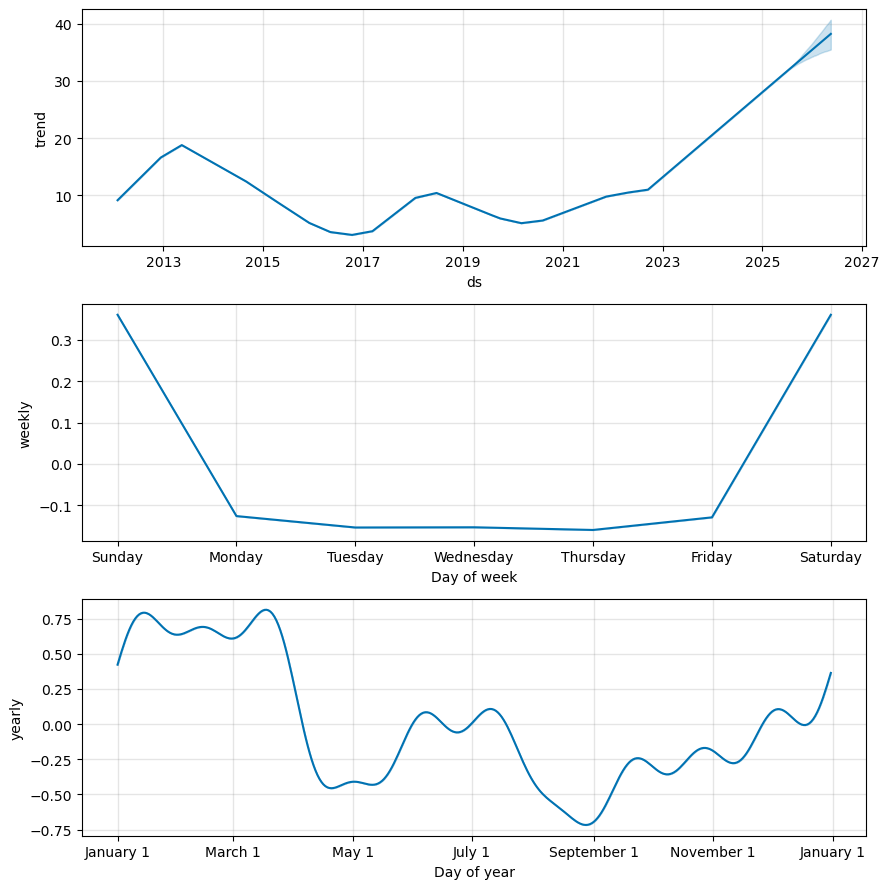

Saved: data/FIRST HOLDCO PLC_forecast.csv and images/FIRST HOLDCO PLC_*.png


In [200]:
# Choosing the top traded companies by volumes for the forecast.
selected_company = companies[48]  # FIRST HOLDCO PLC 
print(f"Running forecast for: {selected_company}")

# Run the forecast for FIRST HOLDCO PLC
forecast = forecast_company(selected_company, periods=365)

Running forecast for: ZENITH BANK PLC


15:40:05 - cmdstanpy - INFO - Chain [1] start processing
15:40:06 - cmdstanpy - INFO - Chain [1] done processing


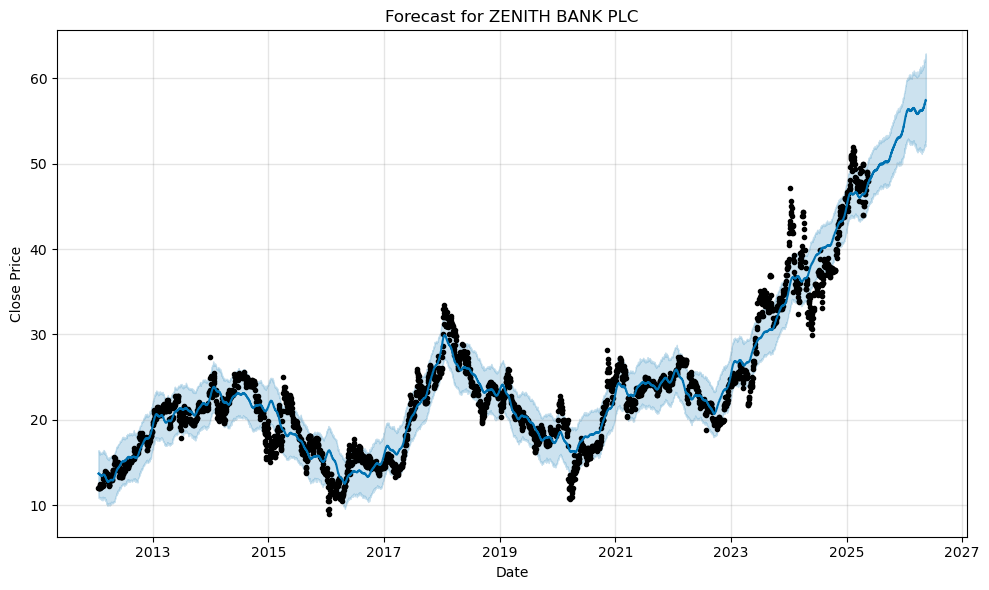

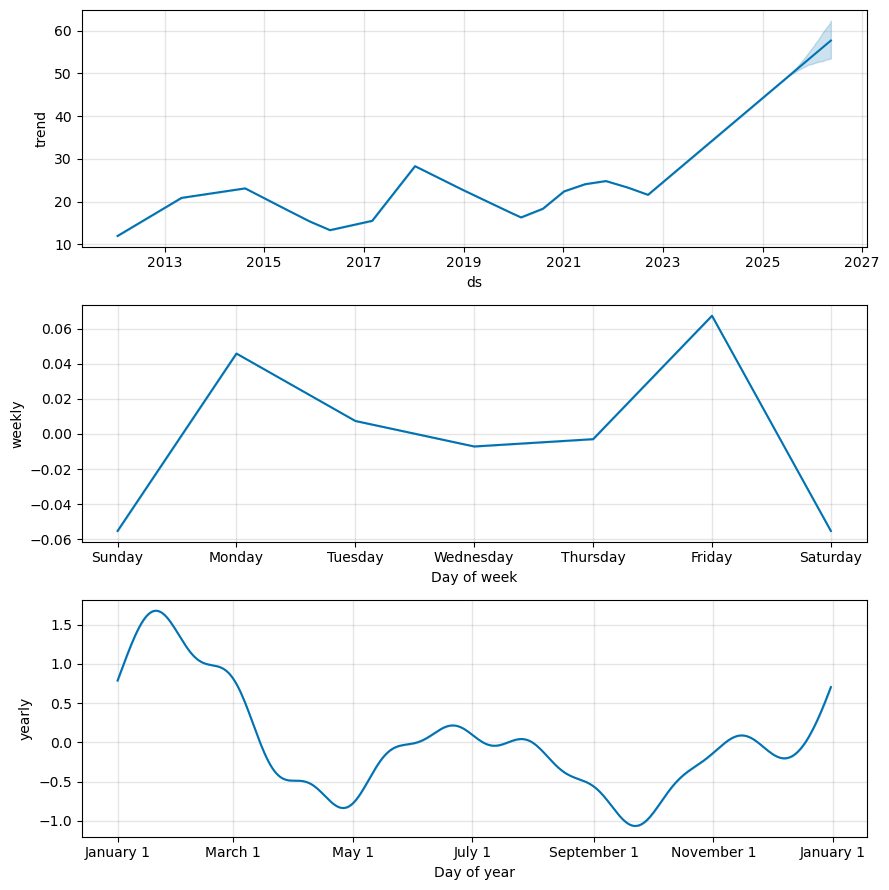

Saved: data/ZENITH BANK PLC_forecast.csv and images/ZENITH BANK PLC_*.png


In [201]:
selected_company = companies[144]  # ZENITH BANK PLC
print(f"Running forecast for: {selected_company}")

# Run the forecast for ZENITH BANK PLC
forecast = forecast_company(selected_company, periods=365)

Running forecast for: NIGERIAN BREW. PLC.


15:40:15 - cmdstanpy - INFO - Chain [1] start processing
15:40:17 - cmdstanpy - INFO - Chain [1] done processing


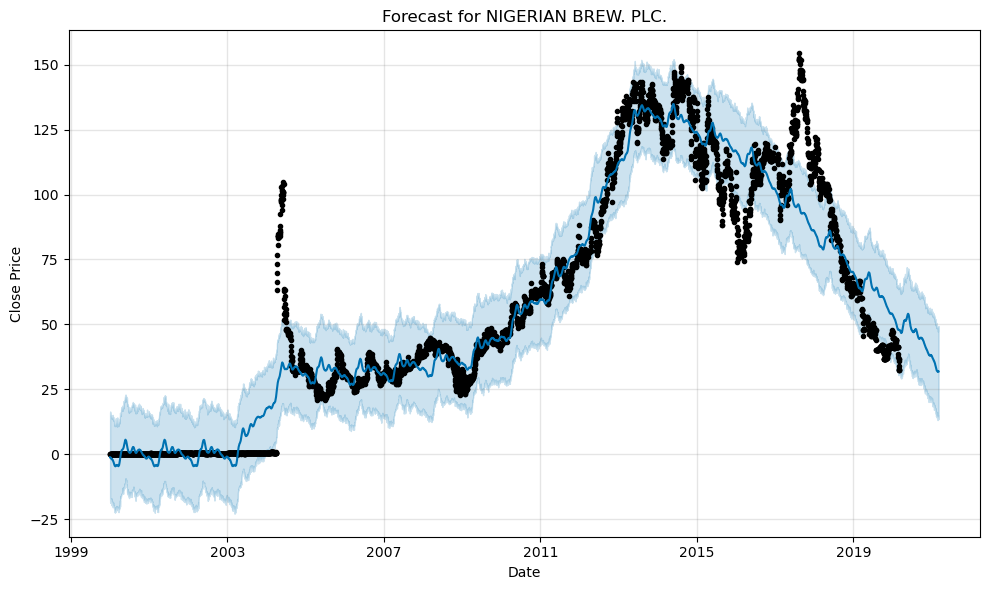

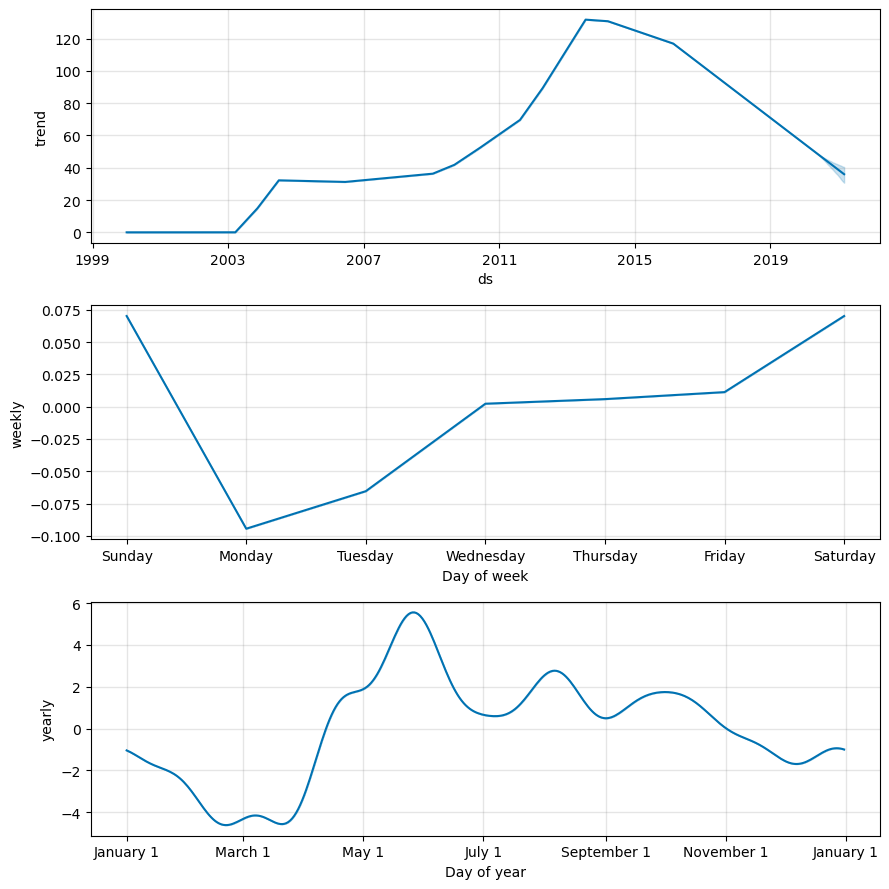

Saved: data/NIGERIAN BREW. PLC._forecast.csv and images/NIGERIAN BREW. PLC._*.png


In [202]:
selected_company = companies[90]  # NB
print(f"Running forecast for: {selected_company}")

# Run the forecast for NIGERIAN BREW. PLC.
forecast = forecast_company(selected_company, periods=365)

Running forecast for: UNITED BANK FOR AFRICA PLC


15:40:26 - cmdstanpy - INFO - Chain [1] start processing
15:40:28 - cmdstanpy - INFO - Chain [1] done processing


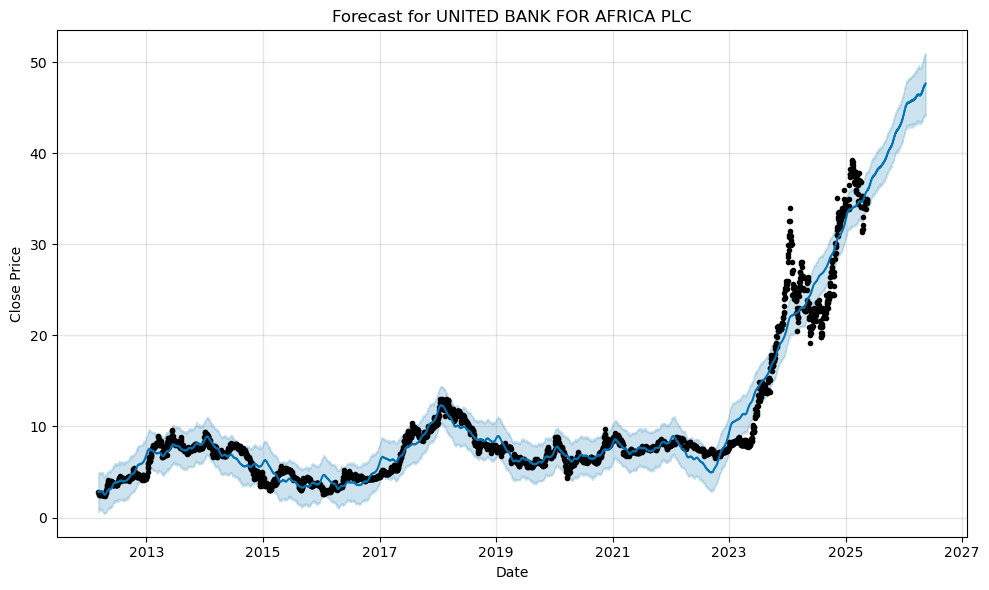

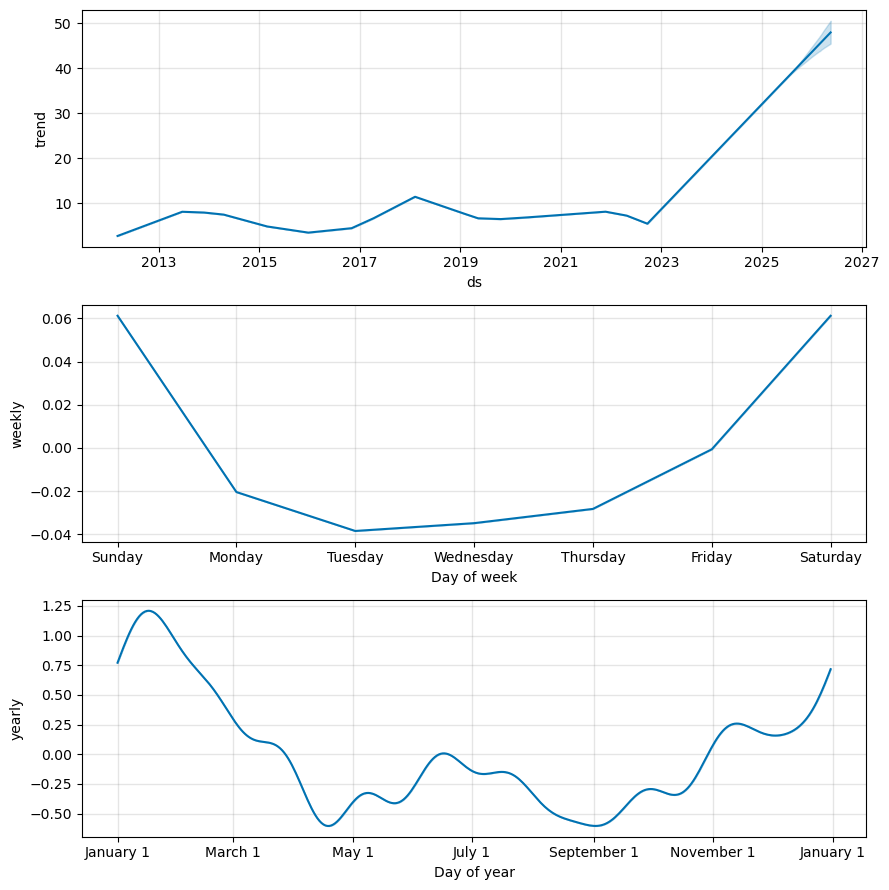

Saved: data/UNITED BANK FOR AFRICA PLC_forecast.csv and images/UNITED BANK FOR AFRICA PLC_*.png


In [203]:
selected_company = companies[133]  # UNITED BANK FOR AFRICA PLC
print(f"Running forecast for: {selected_company}")

# Run the forecast for UNITED BANK FOR AFRICA PLC
forecast = forecast_company(selected_company, periods=365)

Running forecast for: TRANSNATIONAL CORPORATION PLC


15:40:36 - cmdstanpy - INFO - Chain [1] start processing
15:40:37 - cmdstanpy - INFO - Chain [1] done processing


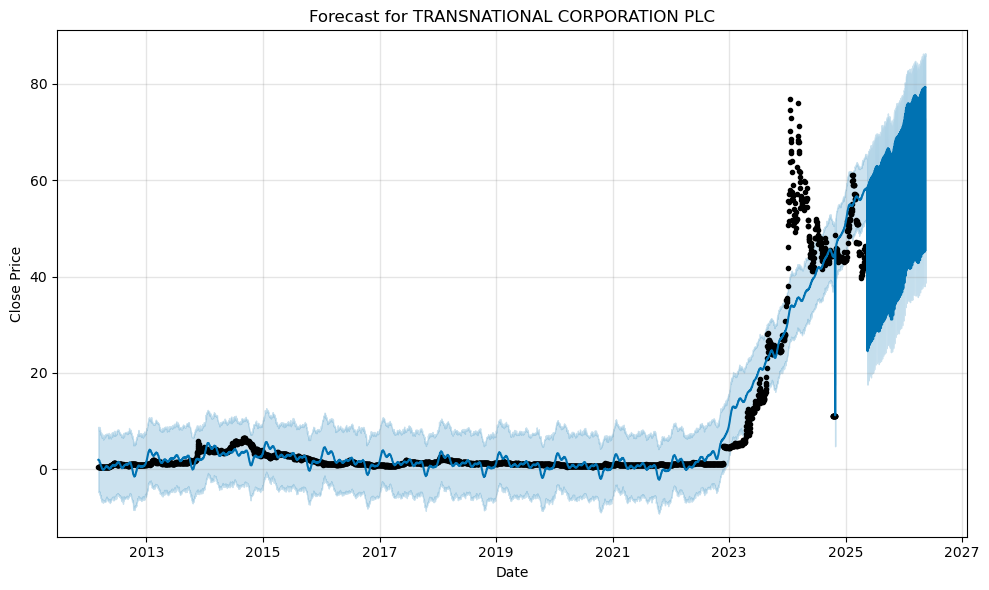

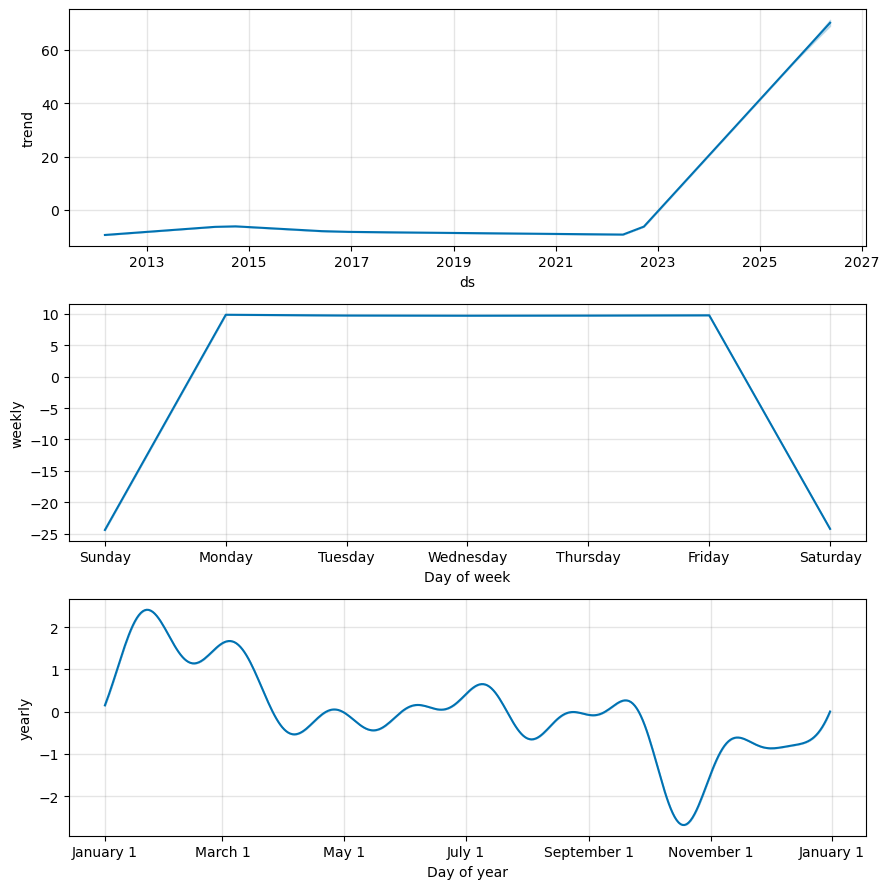

Saved: data/TRANSNATIONAL CORPORATION PLC_forecast.csv and images/TRANSNATIONAL CORPORATION PLC_*.png


In [204]:
selected_company = companies[127]  # TRANSCORP
print(f"Running forecast for: {selected_company}")

# Run the forecast for TRANSNATIONAL CORPORATION PLC
forecast = forecast_company(selected_company, periods=365)

# Forecasting and Comparative Analysis of Top 5 Nigerian Stocks

In this notebook, here I analyze the **top 5 Nigerian companies by trading volume**:  
- **FIRSTHOLDCO**  
- **ZENITHBANK**  
- **NB (Nigerian Breweries)**  
- **UBA (United Bank for Africa)**  
- **TRANSCORP**  

The analysis covers:  
1. **Forecasting with Prophet** – Train Prophet models for each stock and forecast future trends.  
2. **Model Evaluation** – Assess forecast accuracy using MAE, RMSE, and MAPE on a holdout window.  
3. **Trend Analysis** – Estimate trend slopes and cumulative growth over the forecast horizon.  
4. **Volatility Comparison** – Compare rolling 30-day standard deviations of returns.  
5. **Correlation Matrix** – Explore correlations among daily returns of the 5 stocks.  
6. **Relative Performance** – Normalize stock prices to 100 for performance comparison over time.  

This provides insights into forecasting accuracy, risk, co-movement, and comparative performance of the Nigerian stock market leaders.

In [206]:
# 1. Load the stock data
df = pd.read_csv("C:/Users/DELL/Downloads/top_5_stocks_by_volume.csv", parse_dates=["Date"])

# The top 5 companies by volume
top5 = ["FIRSTHOLDCO", "ZENITHBANK", "NB", "UBA", "TRANSCORP"]
df = df[df["Company"].isin(top5)]

# 2. Prophet Forecast & Evaluation
results = []
forecast_horizon = 60  # 60 trading days holdout

for company in top5:
    data = df[df["Company"] == company][["Date", "Price"]].rename(
        columns={"Date": "ds", "Price": "y"}
    )
    data = data.sort_values("ds")

    # Train-test split
    train = data.iloc[:-forecast_horizon]
    test = data.iloc[-forecast_horizon:]

    # Train Prophet
    model = Prophet(daily_seasonality=False, yearly_seasonality=True, weekly_seasonality=False)
    model.fit(train)

    # Forecast
    future = model.make_future_dataframe(periods=forecast_horizon)
    forecast = model.predict(future)

    # Evaluation on holdout
    y_true = test["y"].values
    y_pred = forecast.iloc[-forecast_horizon:]["yhat"].values

    mae = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    # Trend slope (average daily growth in trend component)
    trend = forecast[["ds", "trend"]].set_index("ds")
    slope = trend["trend"].diff().mean()

    # Forecasted cumulative growth
    start_val = forecast.iloc[-forecast_horizon]["trend"]
    end_val = forecast.iloc[-1]["trend"]
    cum_growth = (end_val - start_val) / start_val * 100

    results.append({
        "Company": company,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
        "Trend Slope": slope,
        "Forecasted Growth (%)": cum_growth
    })

# Collect results
eval_df = pd.DataFrame(results)
print("\n📊 Model Evaluation Results:")
print(eval_df)

15:40:44 - cmdstanpy - INFO - Chain [1] start processing
15:40:45 - cmdstanpy - INFO - Chain [1] done processing
15:40:47 - cmdstanpy - INFO - Chain [1] start processing
15:40:48 - cmdstanpy - INFO - Chain [1] done processing
15:40:50 - cmdstanpy - INFO - Chain [1] start processing
15:40:52 - cmdstanpy - INFO - Chain [1] done processing
15:40:54 - cmdstanpy - INFO - Chain [1] start processing
15:40:55 - cmdstanpy - INFO - Chain [1] done processing
15:40:57 - cmdstanpy - INFO - Chain [1] start processing
15:40:57 - cmdstanpy - INFO - Chain [1] done processing



📊 Model Evaluation Results:
       Company        MAE       RMSE   MAPE (%)  Trend Slope  \
0  FIRSTHOLDCO   3.904046   4.490686  15.161151     0.006628   
1   ZENITHBANK   2.808167   3.099273   5.794227     0.010283   
2           NB  15.311450  15.542165  37.702447     0.011399   
3          UBA   2.659439   3.068548   7.310858     0.009636   
4    TRANSCORP  12.106347  13.520969  27.243584     0.018345   

   Forecasted Growth (%)  
0               4.202834  
1               3.253149  
2              -3.914162  
3               5.334297  
4               6.337914  


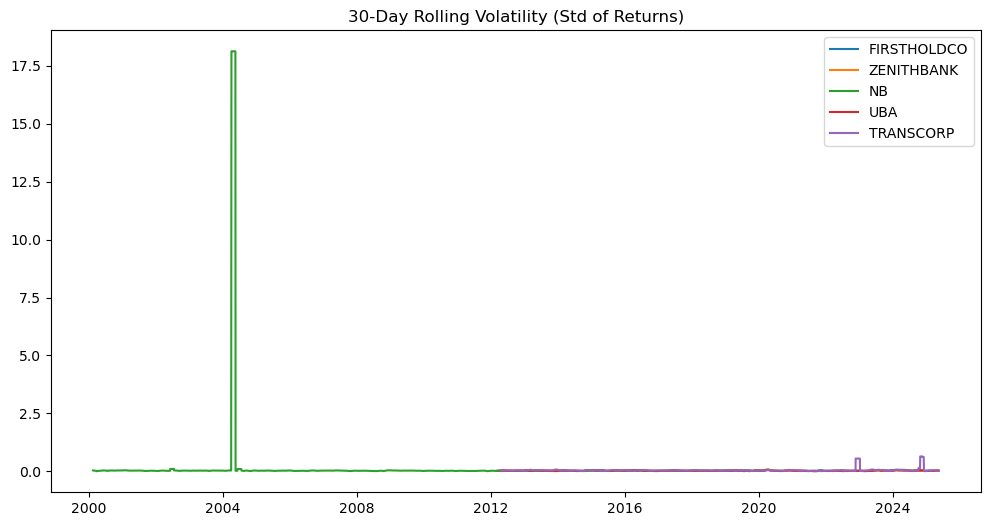

In [207]:
# 3. Volatility (30-day rolling std of returns)
vol_df = pd.DataFrame()

for company in top5:
    data = df[df["Company"] == company][["Date", "Price"]].sort_values("Date")
    data["Return"] = data["Price"].pct_change()
    data["Volatility_30d"] = data["Return"].rolling(window=30).std()
    data["Company"] = company
    vol_df = pd.concat([vol_df, data])
    

plt.figure(figsize=(12,6))
for company in top5:
    subset = vol_df[vol_df["Company"] == company]
    plt.plot(subset["Date"], subset["Volatility_30d"], label=company)
plt.legend()
plt.title("30-Day Rolling Volatility (Std of Returns)")
plt.savefig(f"images/volatility_comparsion.png", dpi=300, bbox_inches="tight")
plt.show()

C:\Users\DELL\AppData\Local\Temp\ipykernel_16268\2018751851.py:3: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  returns = pivot_df.pct_change().dropna()


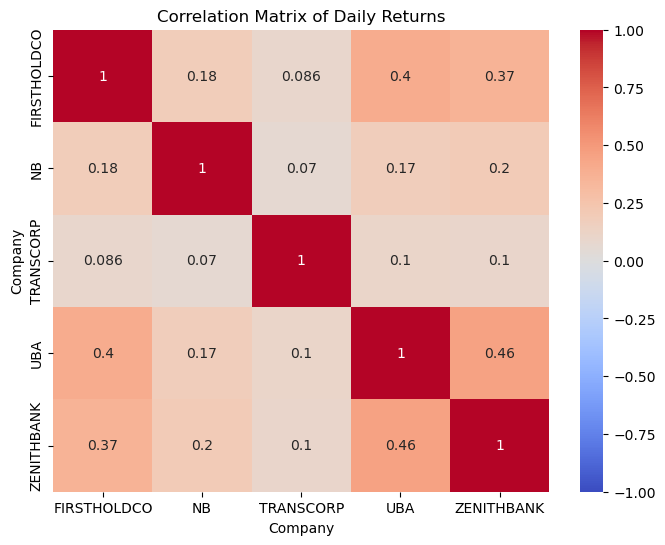

In [208]:
# 4. Correlation Matrix of Returns
pivot_df = df.pivot(index="Date", columns="Company", values="Price")
returns = pivot_df.pct_change().dropna()

corr = returns.corr()

plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Daily Returns")
plt.savefig(f"images/correlation_matrix.png", dpi=300, bbox_inches="tight")
plt.show()

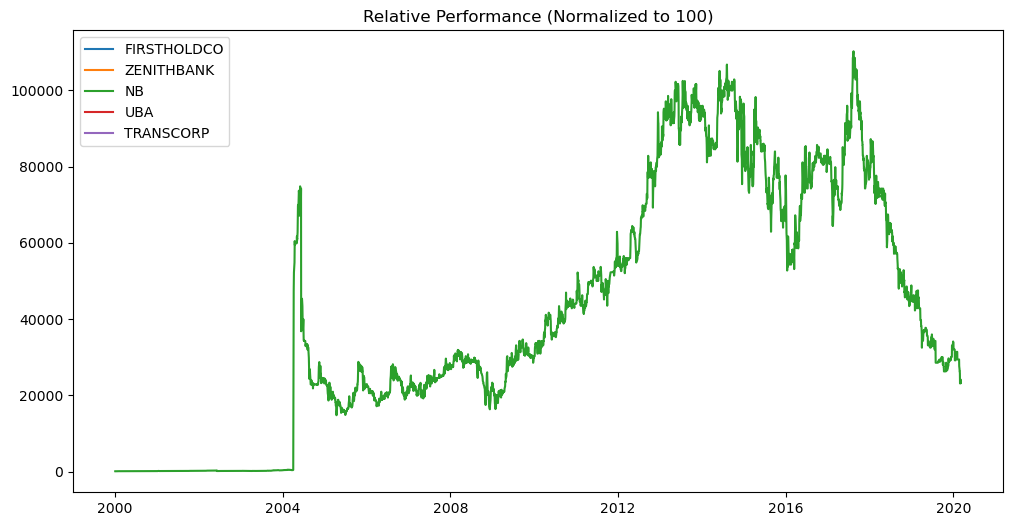

In [209]:
# 5. Relative Performance (Normalize to 100)
# --------------------
norm_df = pivot_df / pivot_df.iloc[0] * 100

plt.figure(figsize=(12,6))
for company in top5:
    plt.plot(norm_df.index, norm_df[company], label=company)
plt.legend()
plt.title("Relative Performance (Normalized to 100)")
plt.savefig(f"images/relative performance.png", dpi=300, bbox_inches="tight")
plt.show()